In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import math
import statsmodels.api as sm
import warnings
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
import tensorflow as tf, keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
import shap

import plotly.graph_objects as go
import plotly.offline as pyo
import kaleido

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
# Load the .npz file
data = np.load('data.npz')

# Access X and y from the loaded data
X = data['X']
y = data['y']

#Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = y_train[:, 0, :]

#Load Model
model = tf.keras.models.load_model('CNN_model_1.h5')

# Predicting the Values of the Training Data to be test data for surrogate model
predictions = model.predict(X_train)

Metal device set to: Apple M1 Pro


2023-11-20 15:54:17.728098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 15:54:17.728925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-20 15:54:21.794381: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-20 15:54:21.866058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 8s 31ms/step


In [3]:
final_preds = np.copy(predictions)
for i in range (127):
    final_preds = np.concatenate((final_preds, predictions), axis = 0)

In [5]:
#Reshaping Data to Be Compatable with Decision Tree and Shape (2D)
X_train_reshaped = X_train.reshape(22441408, 32)
X_train_reshaped = X_train_reshaped[0:1028096]

#IMporting Random Forest Tree to Mimic the Model as a Surrogate
from sklearn.ensemble import RandomForestRegressor  # Example, choose an appropriate model

X_train_reshaped = X_train_reshaped[0:100000]
final_preds = final_preds[0:100000]

#Fitting the Model to a Random Forest as best as possible
surrogate_model = RandomForestRegressor()
surrogate_model.fit(X_train_reshaped, final_preds)

RandomForestRegressor()

In [86]:
from sklearn.tree import _tree
from operator import itemgetter

#Names the Features
feature_names = ['x', 'y', 's', 'a', 'dis', 'o', 'dir',
       'height', 'weight', 'age', 'distance_to_ballCarrier', 'C', 'CB',
       'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'MLB', 'NT', 'OLB', 'QB',
       'RB', 'SS', 'T', 'TE', 'WR', 'Defense', 'Offense', 'ballCarrier']

#Measures the Importances of Features for the Random Forest Model which Mimics the Output of the Neural Network
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) - 0.026:
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

#Gets the Most Important Features
vars_tree_flag = getEnsembleTreeVars( surrogate_model, feature_names)
sorted_vars_tree_flag = sorted(vars_tree_flag)

In [87]:
features = []
values = []
for i in range(len(sorted_vars_tree_flag)):
    features.append(sorted_vars_tree_flag[i][0])
    values.append(sorted_vars_tree_flag[i][1])

In [2]:
values = [99, 17, 100, 48, 88, 16, 89, 75, 24, 85, 86]

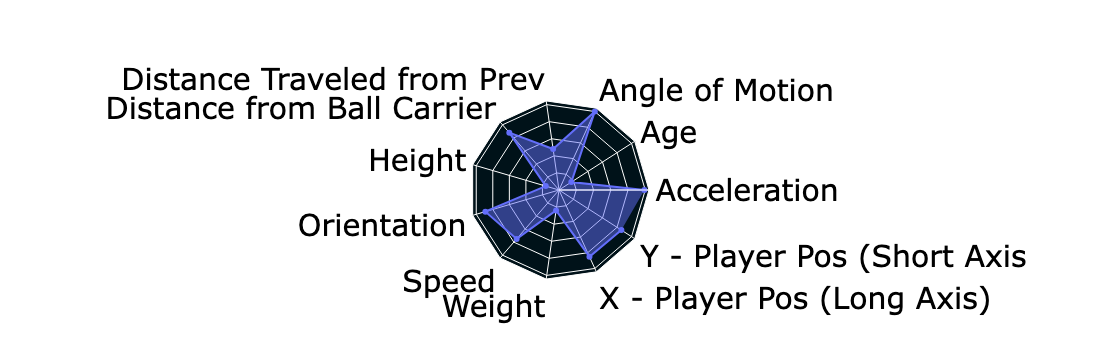

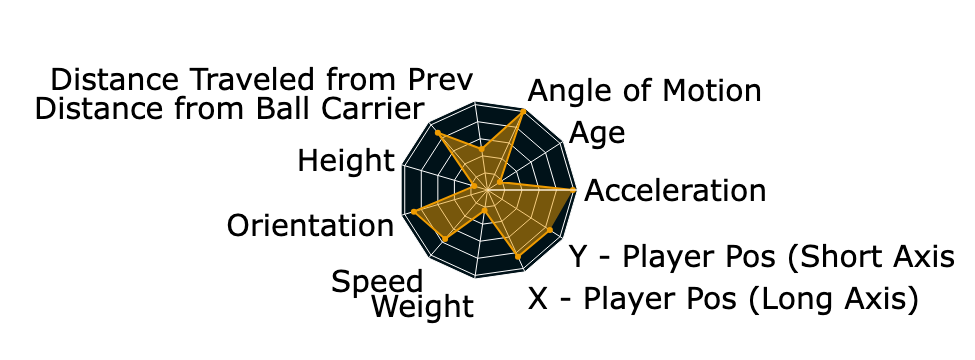

In [9]:
# Create a trace for the radar chart
long_names = ['Acceleration', 'Age', 'Angle of Motion', 'Distance Traveled from Prev','Distance from Ball Carrier', 'Height', 'Orientation', 'Speed', 
             'Weight', 'X - Player Pos (Long Axis)', 'Y - Player Pos (Short Axis']
import kaleido
custom_tickvals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
custom_ticktext = [str(val) for val in custom_tickvals]

fig = go.Figure(layout = None)
fig = fig.add_trace(go.Scatterpolar(
      r=values,
      theta=long_names,
      fill='toself',
      name='Tackle Efficiency',
))

fig = fig.update_polars(angularaxis_showgrid=True,
              radialaxis_gridwidth=0,
              gridshape='linear',
              bgcolor="#001219",
              radialaxis_showticklabels=False
              )

fig.update_layout(plot_bgcolor='#FFFFFF', 
                      paper_bgcolor='rgba(0,0,0,0)', 
                      font=dict(color='black', size=30),)

fig = fig.update_traces(visible=True, 
                  marker=dict(color='#EE9B00'))

fig.show()
fig.write_image("./Images/feature_Importance_Radar.png", width = '1900', height = '1200')

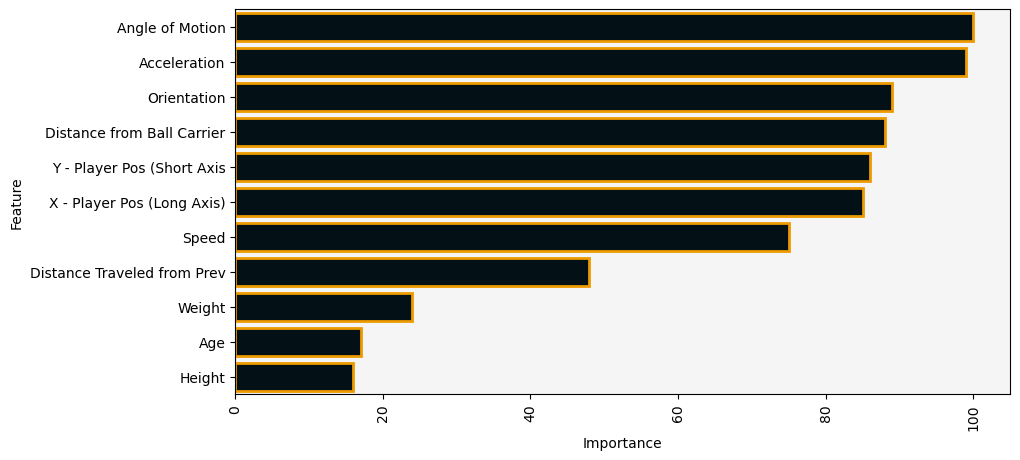

In [15]:
df = pd.DataFrame({'LN':long_names, 'Vals':values}, columns = ['LN','Vals'])

palette = ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6", 
           "#EE9B00", "#CA6702", "#BB3E03", "#AE2012"]

colors_full = sns.color_palette(palette, 9)
fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.barplot(data = df, y = 'LN', x = 'Vals', order = df.sort_values('Vals', ascending = False).LN,
           color = palette[0], edgecolor = palette[5], linewidth = 2)
names = plt.xlabel("Importance") 
rotation = plt.xticks(rotation=90) 
lables = plt.ylabel("Feature")
bg = ax.set_facecolor('#F5F5F5')

plt.savefig('./Images/feature_Importance_Bar.png', format='png', dpi=300, transparent=True, bbox_inches = "tight")